# Word Embeddings for The Office transcript data

This workbook is using text data from the US series The Office. Concretely, the complete dialogue/transcript is used to train word2vec and GloVe embeddings. First, the data is imported, cleaned, and transformed before an exploratory data analysis is carried out. This should help to get a better understanding of the data before in the main part of this notebook a Word2Vec model is created, and the embedding spaces are visualized. Later, the embeddings are then compared to a pretrained GloVe (`glove-wiki-gigaword-100`) as well as Fasttext (`fasttext-wiki-news-subwords-300`) model and as a last step compared to WordNet. 


**Context:** The series [*The Office (US)*](https://en.wikipedia.org/wiki/The_Office_(American_TV_series) is an 2005 aired mockumentary sitcom. The series is about the daily work life of office employees at Dunder Mifflin a paper company in Scranton, Pennsylvania. At the heart of it is Michael Scott (played by Steve Carrell) the regional manager, who characterizes a"goofy" boss. [This video](https://www.youtube.com/watch?v=PeqbzOZhccI) should give a short overview of Michael Scott and the other characters in the series. When creating our own Word2Vec model we assume that characters that have a close relationship in the series are closer together in the embedding space. Additionally, we expect that our own model will get learn the context of specific words and calculate them as close together (e.g. *Dunder* & *Mifflin*, *first* & *last names*, *sales* & *paper*). 

#### **🎯 Goals**
* Load the Office transcript data, clean the data, and transform them to be ready for analysis.
* Train own Word2Vec model and visualize the embedding space as well as the embedding space for similar words.
* Compare the own Word2Vec model embeddings to a pretrained embedding space and evaluate the pros and cons of both methods.



#### **❓ Questions**

Based on our assumptions, we want to answer the following questions:
* Which are the main characters of the Office when it comes to the number of lines they have?
* Are relationships of different characters visible in the embedding space? (e.g. Jim and Pam become very close friends during the series and afterward marry each other).
* What kind of words lay close together when we visualize our embedding space? 
* What are the similar words to the central words of the series (e.g. paper, office), and do they make sense?
* What are the differences between our own model and a pretrained embedding space?

## Setup

We start by importing the needed libraries for our analysis and model creation. The data for this notebook was found on [Kaggle](https://www.kaggle.com/datasets/nasirkhalid24/the-office-us-complete-dialoguetranscript) and downloaded as well as stored on a Dropbox to facilitate the import.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict  # For word frequency

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# nlp libraries
import spacy # preprocessing
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt') # Needed for tokenization
from gensim.parsing.preprocessing import preprocess_string, strip_non_alphanum, strip_multiple_whitespaces, strip_punctuation, remove_stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models.wrappers import FastText

# PCA
from sklearn.manifold import TSNE


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!wget https://www.dropbox.com/s/nmjmmtihlqcbeul/The-Office-Lines-V4.csv?dl=0

--2022-12-15 09:45:44--  https://www.dropbox.com/s/nmjmmtihlqcbeul/The-Office-Lines-V4.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nmjmmtihlqcbeul/The-Office-Lines-V4.csv [following]
--2022-12-15 09:45:44--  https://www.dropbox.com/s/raw/nmjmmtihlqcbeul/The-Office-Lines-V4.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc7e37c72b02f29e7f539c8f8d5.dl.dropboxusercontent.com/cd/0/inline/Byp4QjopjIhVTQqDf38uMF38ZXcbsEYo8csiAlwKYuDi9LHEO6WYOL4LDEqdagjYz07lUqsMSI0V2pc2Y2bilhil4tvvd6CyeJ0sUDgiK-6omd15nedEaGQcsooZx7Fw8PueQKz4h-02Xd01ZZAa1zgI1iSNq8ecbJd57wMWz0M1vA/file# [following]
--2022-12-15 09:45:45--  https://ucc7e37c72b02f29e7f539c8f8d5.dl.dropboxusercontent.com/cd/0/inline/Byp4QjopjIhVTQqDf38uMF38ZXcbsEYo8csiAlwKYu

In [ ]:
# Load the dataset and create dataframe
the_office_transcript = Path("./") / 'The-Office-Lines-V4.csv?dl=0'
the_office_df = pd.read_csv(the_office_transcript, usecols=['season', 'episode', 'title', 'speaker', 'line'])
the_office_df.head()

,season,episode,title,speaker,line
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,Michael,"All right. Well, let me show you how it's done."


In [ ]:
the_office_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54626 entries, 0 to 54625
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   season   54626 non-null  int64 
 1   episode  54626 non-null  int64 
 2   title    54626 non-null  object
 3   speaker  54626 non-null  object
 4   line     54626 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.1+ MB


In [ ]:
# inspect NA
the_office_df.isna().sum()

season     0
episode    0
title      0
speaker    0
line       0
dtype: int64

In [ ]:
# Visualize random lines
np.random.seed(100)
for i in range(4):
  random_index = the_office_df.index
  random_line = np.random.choice(random_index)
  print(the_office_df.iloc[random_line]['line'])

Ha! This is gonna show them  that I mean business. See ya! 
And his name is... Garbage. Mose calls him Garbage because he likes to eat garbage.  Don't you Garbage? 
Wow, that is... that time really adds up. That's like... a half an hour, every hour?
Howard, like Moe Howard. Three Stooges.


In order to start working with our dataset, it's important to familiarize ourselves with it. We see that we have in total 5 variables (2 integers and 3 as string/text) whereas all of them consist of no NA values (lucky us!). When inspecting random lines of the dataset (the target variable that we will use for training our embeddings), we see that they are of different length, consist of upper- as well as lowercase characters, can have multiple symbols in it (e.g. `...`) and can have multiple whitespaces between words (e.g. `them  that`). Let's clean this up in the next step and continue exploring our dataset further afterward.

## Clean the text

Our goal is to have text that can be compared to each other. Therefore, we will clean our text which is stored in the `line`-variable, by doing the following things:

* Lemmatize our words (get the base or dictionary form of a word)
* Make the text lowercase
* Remove punctuation as well as non alpha numerical characters (e.g `!`, `?`)
* Remove stop words
* Remove multiple whitespaces

In [ ]:
# Clean the data with the help of gensim preprocessing (see: https://radimrehurek.com/gensim/parsing/preprocessing.html)
def clean_text(x: str):
  """ 
  Cleans text by doing the following things:
    - Lemmatize text
    - Make text lowercase
    - Remove non alpha numerical characters
    - Remove stopwords
    - Remove punctuation
    - Remove multiple whitespace
  """
  custom_filters = [strip_non_alphanum, remove_stopwords,
                    strip_punctuation, strip_multiple_whitespaces]

  
  # Lemmatize text (see: https://spacy.io/usage/linguistic-features#lemmatization)
  lemmatizer = nlp.get_pipe("lemmatizer")

  # Make text lowercase
  text = x.lower()

  # Note: Takes around 8 minutes
  text = " ".join([token.lemma_ for token in nlp(text)])

  # Apply filters to text
  text = " ".join(preprocess_string(text, custom_filters))

  # Lower text again in order a word was not found
  text = text.lower()

  return text

In [ ]:
# Clean the text
the_office_df['clean_text'] = the_office_df['line'].apply(lambda x: clean_text(x))

In [ ]:
the_office_df.head(5)

,season,episode,title,speaker,line,clean_text
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good...,right jim quarterly look good thing library
1,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...",oh i tell i close
2,1,1,Pilot,Michael,So you've come to the master for guidance? Is ...,ve come master guidance grasshopper
3,1,1,Pilot,Jim,"Actually, you called me in here, but yeah.",actually i yeah
4,1,1,Pilot,Michael,"All right. Well, let me show you how it's done.",right let i


We now have a new variable `clean_text` that represents the text in a format that can be compared to each other and used for our analysis and embeddings. Next, let's inspect and clean the speakers so that we can find the main characters by aggregating.

In [ ]:
# Let's inspect the speakers
for speaker in the_office_df['speaker'].unique():
  print(speaker)

Michael
Jim
Pam
Dwight
Jan
Michel
Todd Packer
Phyllis
Stanley
Oscar
Angela
Kevin
Ryan
Man
Roy
Mr. Brown
Toby
Kelly
Meredith
Travel Agent
Man on Phone
Everybody
Lonny
Darryl
Teammates
Michael and Dwight
Warehouse worker
Madge
Worker
Katy
Guy at bar
Other Guy at Bar
Guy At Bar
Pam and Jim
Employee
Chili's Employee
Warehouse Guy
Warehouse guy
Man in Video
Video
Actor
Redheaded Actress
Mr. O'Malley
Albiny
Pam's Mom
Carol
Bill
Everyone
Crowd
song
Song
Dwight and Michael
Sherri
Creed
Devon
Children
Kid
Ira
Ryan's Voicemail
Christian
Hostess
Michael and Christian
Sadiq (IT guy)
Mark
Improv Teacher
Mary-Beth
Girl acting Pregnant
Actress
Michael and Jim
Kevin & Oscar
All
Liquor Store Clerk
JIm
Bob Vance
Phyllis, Meredith, Michael, Kevin
Captain Jack
Brenda
Darryl and Katy
Jim and Pam
Billy Merchant
Doctor
Lab Tech
Dana
Hooter's Girls
Phylis
Gil
Pam and others
Ed
Packer
Todd
Jim's voicemail
Guy
Group chant
All the Men
Delivery man
Craig
Josh
David
Dan
Overhead
Speaker
Jim and Dwight
Melissa
Sash

In [ ]:
# Get unique number of speaker
the_office_df['speaker'].nunique()

775

Inspecting the speakers, lets us see that we also have to apply some cleaning here. More precisely, we see the following:

* Some speakers have a `:`  or a `.` after their name, and some have a `""` around their name. We need to remove this.
* Some speakers start with whitespace before their name. We need to strip the names.
* There are some second uppercases in the names (e.g. `JIm`, `MIchael`). We need to make naming consistent by lowering them.
* There are some errors in names for Michael (e.g. `M ichael`, `Mihael`, `Michel`). Let's replace them with "Michael". (Remark: There is really no Michel in the office, therefore it's supposed to be Michael)

In [ ]:
# Create speaker cleaner function
def clean_speaker(speaker):
  """
  Cleans the speaker names by:
  - Removing "." or ":" or '"'
  - Strip speaker
  - Lowercase speaker
  - Changing "M ichael" or "Mihael" to "Michael"
  """
  # Remove punctuation (:, .) in names
  speaker = speaker.replace(":", "").replace(".", "").replace('"', "")
  # Strip the names to remove whitespace
  speaker = speaker.strip()
  # Make speaker lowercase
  speaker = speaker.lower()
  # Clean "Michael" speaker
  if (speaker == "m ichael") or (speaker == "mihael") or (speaker == "michel"):
    speaker = "michael"

  return speaker

In [ ]:
# Apply cleaning function
the_office_df['speaker'] = the_office_df['speaker'].apply(lambda x: clean_speaker(x))

In [ ]:
# Inspect speaker once more
for speaker in the_office_df['speaker'].unique():
  print(speaker)

michael
jim
pam
dwight
jan
todd packer
phyllis
stanley
oscar
angela
kevin
ryan
man
roy
mr brown
toby
kelly
meredith
travel agent
man on phone
everybody
lonny
darryl
teammates
michael and dwight
warehouse worker
madge
worker
katy
guy at bar
other guy at bar
pam and jim
employee
chili's employee
warehouse guy
man in video
video
actor
redheaded actress
mr o'malley
albiny
pam's mom
carol
bill
everyone
crowd
song
dwight and michael
sherri
creed
devon
children
kid
ira
ryan's voicemail
christian
hostess
michael and christian
sadiq (it guy)
mark
improv teacher
mary-beth
girl acting pregnant
actress
michael and jim
kevin & oscar
all
liquor store clerk
bob vance
phyllis, meredith, michael, kevin
captain jack
brenda
darryl and katy
jim and pam
billy merchant
doctor
lab tech
dana
hooter's girls
phylis
gil
pam and others
ed
packer
todd
jim's voicemail
guy
group chant
all the men
delivery man
craig
josh
david
dan
overhead
speaker
jim and dwight
melissa
sasha
abby
jake
the kids
kids
miss trudy
edward

In [ ]:
# Get unique number of speaker
the_office_df['speaker'].nunique()

723

In [ ]:
the_office_df.head()

,season,episode,title,speaker,line,clean_text
0,1,1,Pilot,michael,All right Jim. Your quarterlies look very good...,right jim quarterly look good thing library
1,1,1,Pilot,jim,"Oh, I told you. I couldn't close it. So...",oh i tell i close
2,1,1,Pilot,michael,So you've come to the master for guidance? Is ...,ve come master guidance grasshopper
3,1,1,Pilot,jim,"Actually, you called me in here, but yeah.",actually i yeah
4,1,1,Pilot,michael,"All right. Well, let me show you how it's done.",right let i


Cleaning the speakers helped us to get from 775 unique speakers to 723 unique speakers. The names are now also in an identical format, which allows aggregating them.

## Exploratory Data Analysis

Now that we have cleaned the text and speakers in our data frame, let's continue with an exploratory analysis of our data to get to know it better and familiarize ourselves with its characteristics. 

Let's first get some more high-level information about the data. Namely:

* Number of seasons and episodes per season
* Lines per season
* Words per line per season


### Number of season and episodes

In [ ]:
# Get number of episodes per season
episodes_season = the_office_df.groupby('season', as_index=False)['episode'].nunique()
episodes_season

,season,episode
0,1,6
1,2,22
2,3,23
3,4,14
4,5,26
5,6,24
6,7,24
7,8,24
8,9,23


We see that the first season only 6 episodes whereas the following seasons had more than twice as many episodes. Comparing the number of episodes we have in our data with the [actual seasons from an external source](https://en.wikipedia.org/wiki/List_of_The_Office_(American_TV_series)_episodes#Series_overview), we see that some episodes might be missing. For example, we only have 14 episodes in season 4, although it should be 19. And for season 9 it should be 25, but we have only 23. Let's inspect this. 

In [ ]:
# Get episode titles for season 4
the_office_df[the_office_df['season'] == 4]['title'].unique()

array(['Fun Run (Parts 1&2)', 'Dunder Mifflin Infinity (Parts 1&2)',
       'Launch Party (Parts 1&2)', 'Money (Parts 1&2)', 'Local Ad',
       'Branch Wars', 'Survivor Man', 'The Deposition', 'Dinner Party',
       'Chair Model', 'Night Out', 'Did I Stutter?', 'Job Fair',
       'Goodbye, Toby (Parts 1&2)'], dtype=object)

In [ ]:
# Get episode titles for season 9
the_office_df[the_office_df['season'] == 9]['title'].unique()

array(['The New Guys', "Roy's Wedding", "Andy's Ancestry", 'Work Bus',
       'Here Comes Treble', 'The Boat', 'The Whale', 'The Target',
       'Dwight Christmas', 'Lice', 'Suit Warehouse', 'Customer Loyalty',
       'Junior Salesman', 'Vandalism', 'Couples Discount', 'Moving On',
       'The Farm', 'Promos', 'Stairmageddon', 'Paper Airplane',
       "Livin' the Dream", 'A.A.R.M', 'Finale'], dtype=object)

We see that some episodes have two parts. Additionally, when we compare the episodes of season 9 with the external source, we see that the episodes `A.A.R.M.` and `Finale` are considered two episodes each. With this in mind, we should have all the episodes and get the same number of episodes as in the external source.

### Lines per Season

Let's next take a closer look at the number of lines per season.

In [ ]:
# Get lines per season
lines_season = the_office_df.groupby('season', as_index=False)['line'].count()
lines_season

,season,line
0,1,1487
1,2,5835
2,3,6291
3,4,4734
4,5,7684
5,6,7588
6,7,7316
7,8,6655
8,9,7036


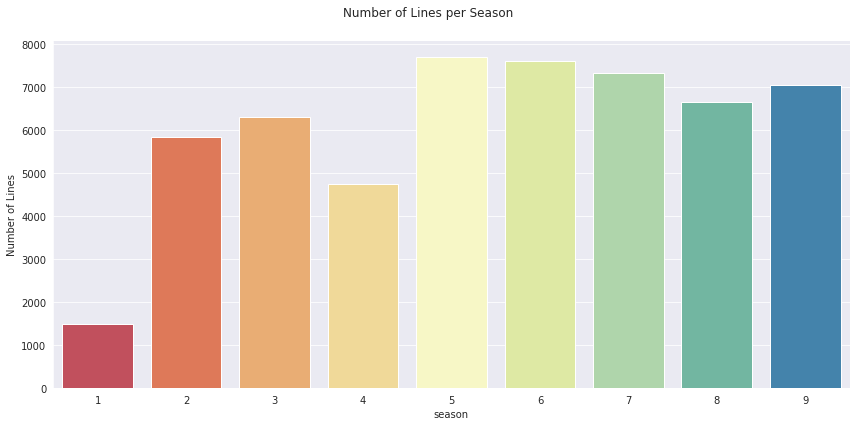

In [ ]:
# Visualize the most speakers
sns.set_style("darkgrid")

bar_plot = sns.catplot(data=lines_season, 
                       x="season", y="line",
                       hue="season",
                       kind="bar",
                       dodge=False,
                       height=6,
                       aspect=2,
                       palette=sns.color_palette("Spectral", 9))

bar_plot.set(ylabel="Number of Lines")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Number of Lines per Season');

We see that season 1 has by far the least number of lines. This could be led back to the fact that season 1 also has the least amount of episodes. Additionally, we see that later episodes from season 5 to 9 have the most number of lines, which also could be due to the fact that seasons 5 to 9 are the seasons with the most episodes. Let's calculate the correlation between the number of episodes and the number of lines.

In [ ]:
# Calculate correlation between number of lines per season and episodes per season
corr_df = pd.merge(episodes_season, lines_season, on="season")
corr_df.corr().loc["episode", "line"].round(2)

0.97

As assumed, there is a high correlation between the number of episodes and the number of lines. 

### Words per line per season

So far we inspected the number of lines per season and saw that they highly correlate with the number of episodes of a season. However, a line can be of different length. Let's, therefore, inspect the average number of words per line per season. For this, we will use the initial `line`-variable that still consists of stop words.

In [ ]:
# Calculate number of words per line
the_office_df["number_words"] = the_office_df["line"].apply(lambda x: len(x.split())) 

In [ ]:
# Visualize
fig = px.box(the_office_df, y="number_words", color="season",
             custom_data=["title", "speaker", "season"],
             title="Comparison of distribution number of words per line per season",
             template="seaborn")

fig.update_traces(
    hovertemplate="<br>".join([
        "Speaker: %{customdata[1]}",
        "Number of words in line: %{y}",
        "Title of episode: %{customdata[0]}",
        "Season: %{customdata[2]}"
    ])
)

fig.update_layout(
    legend_title="Season",
    yaxis_title="Number of words"
)
fig.show()

Interestingly, we see that on average (median) a line per season consists of 6 words until season 5 and then 7 words for seasons 6 until 9. All box plots consist of multiple outliers larger than the upper whisker, which speaks for a right-skewed distribution. This means, generally lines are of shorter length, but there are multiple lines where a speaker has a line with substantially more words.

Let us for example look at the outlier in season 3, which comes from a line of Pam in the episode Beach Games.

In [ ]:
import pprint
pprint.pprint(the_office_df[the_office_df['number_words'] == 232]['line'][13117])

(" Hey! I want to say something. I've been trying to be more honest lately and "
 'I just need to say a few things. I did the coal walk! Just, I did it! '
 "Michael, you couldn't even do that. Maybe I should be your boss? Wow, I feel "
 "really good right now. Why didn't any of you come to my art show? I invited "
 "all of you. That really sucked. It's like sometimes some of you act like I "
 "don't even exist.  Jim, I called off my wedding because of you. And now "
 "we're not even friends. And things are just like weird between us, and that "
 'sucks. And I miss you. You were my best friend before you went to Stamford, '
 "and I really miss you. I shouldn't have been with Roy. And there were a lot "
 "of reasons to call off my wedding. But the truth is, I didn't care about any "
 "of those reasons until I met you. And now you're with someone else. And "
 "that's... fine. It's... whatever. That's not what... I'm not... Okay, my "
 "feet really hurt. The thing that I'm just trying to s

We now know who had the line with the most words for the whole series and what it was about. Nice!

Additionally, since we are interested in the whole text and the outliers represent a central characteristic of the dataset, we will deal with the outliers by leaving them there.

### Speakers

Let's next dive a bit deeper into our different speakers and figure out which are the main characters when it comes to the number of lines. First, we would like to know how many different speakers there are and which characters have the most lines per season.

In [ ]:
# Number of unique speakers
the_office_df['speaker'].nunique()

723

As seen in the cleaning part, we have a total of 723 unique speakers. Based on the first inspection, it can also be that two characters say the same line and are considered as one speaker.
Let's next find out who are the speakers with the most lines.

In [ ]:
# Count lines per speaker per season
most_speaker = the_office_df.groupby(['speaker', 'season'], as_index=False)['line'].count()
most_speaker
# Get the 5 most speaker per season
most_speaker = most_speaker.groupby('season', as_index=False).apply(lambda x: x.sort_values(by='line', ascending=False).head(5)).reset_index(drop=True)

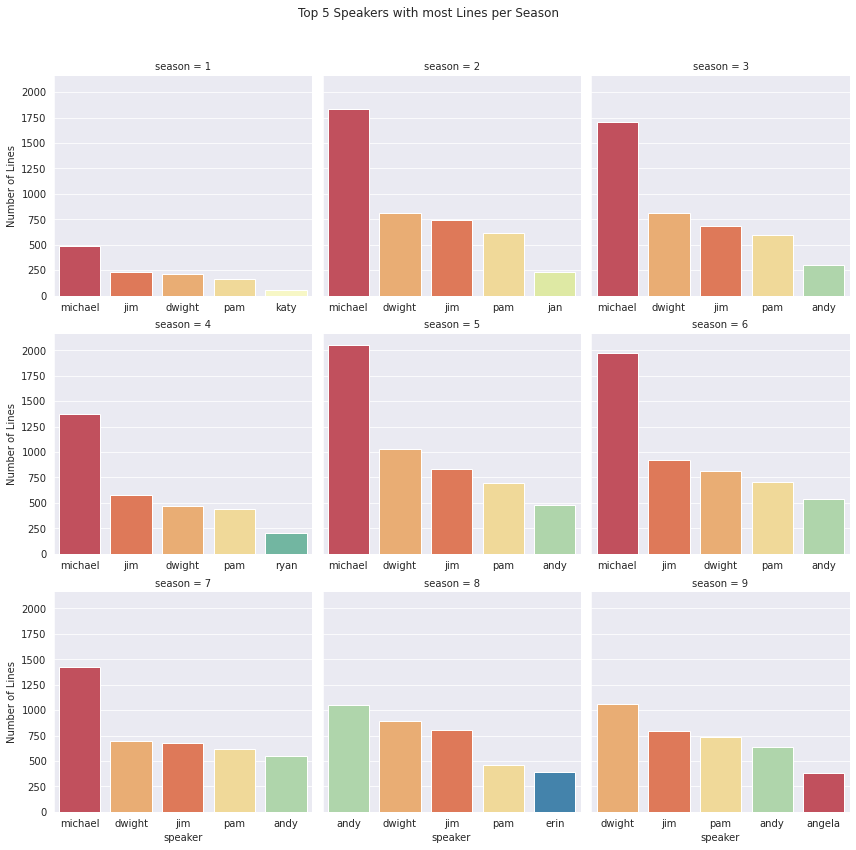

In [ ]:
# Visualize the most speakers
bar_plot = sns.catplot(data=most_speaker, 
                       x="speaker", y="line",
                       col="season",
                       hue="speaker",
                       col_wrap=3,
                       kind="bar",
                       dodge=False,
                       sharex=False,
                       height=4,
                       palette=sns.color_palette("Spectral", 9))

bar_plot.set(ylabel="Number of Lines")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Top 5 Speakers with most Lines per Season');

We see that Michael, Dwight, Jim, and Pam can be considered to be the main characters of the series. Michael is not there anymore in season 8, and he then gets replaced by Andy. However, let's focus on Michael, Dwight, Jim, and Pam and see which words they use the most (without including stop words). For this, we need to concatenate every text for a speaker into one and calculate the used number of words.

In [ ]:
# Filter for text per speaker
michael_text = the_office_df[the_office_df['speaker'] == 'michael']['clean_text'].str.cat(sep=" ")
dwight_text = the_office_df[the_office_df['speaker'] == 'dwight']['clean_text'].str.cat(sep=" ")
jim_text = the_office_df[the_office_df['speaker'] == 'jim']['clean_text'].str.cat(sep=" ")
pam_text = the_office_df[the_office_df['speaker'] == 'pam']['clean_text'].str.cat(sep=" ")

Let's also remove some more words from this that are not considered as stopwords, but are used very often in English.

In [ ]:
# Create function
def words_remover(x):
  """
  Removes words that are fequently used in English, but are note considered stopwords.
  """
  remove_list = [" oh ", " okay ", " know ", " like ", " yes ", " no ",
                 " hey ", " yeah ", " ok "]

  for i in remove_list:
    x = x.replace(i,'')
      
  return x

In [ ]:
# Apply function to text
michael_text = words_remover(michael_text)
dwight_text = words_remover(dwight_text)
jim_text = words_remover(jim_text)
pam_text = words_remover(pam_text)
michael_text

'right jim quarterly look good thing library ve come master guidance grasshopper right let iispeak office managerhello michael scott i regional manager dunder mifflin paper product want talk manager manger right deal thank sir gentleman scholari sorryi sorry mistake woman i talk low voice probably smoker way i ve uh i ve dunder mifflin 12 year regional manager want come entire floor kingdom far eye receptionist pam pam pam pam pam beesly pam forever right pam think cute couple year ago messagepam corporate time i tell special filing cabinet thing corporate wastepaper basket look look face people i good boss god ve work placehilarious good i think pretty sum i spencer gift whassup whassup whass right later work corporate interfere i jan levinson gould jan hello i hillary rodham clinton right face i scared i umum i agenda i agenda i fax morning hand company run efficiency communication right problem pam ijoke joke actually brother s suppose work great faxyeah lovely thankgood good fine e

In [ ]:
# Get unigram counts for every speaker subset and create dataframes
n = 1
# michael
tokens = nltk.word_tokenize(michael_text)
michael_words = pd.DataFrame(pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]).reset_index()
michael_words['speaker'] = 'michael'
# dwight
tokens = nltk.word_tokenize(dwight_text)
dwight_words = pd.DataFrame(pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]).reset_index()
dwight_words['speaker'] = 'dwight'
# jim
tokens = nltk.word_tokenize(jim_text)
jim_words = pd.DataFrame(pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]).reset_index()
jim_words['speaker'] = 'jim'
# pam
tokens = nltk.word_tokenize(pam_text)
pam_words = pd.DataFrame(pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]).reset_index()
pam_words['speaker'] = 'pam'

In [ ]:
# Concatenate dataframes of most frequent words
words_df = pd.concat([michael_words, dwight_words, jim_words, pam_words]).rename(columns={"index": "word", 0:'count'})

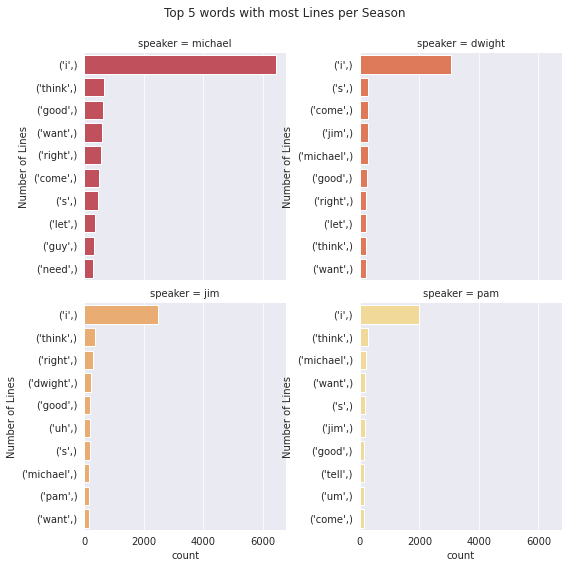

In [ ]:
# Visualize the most speakers
bar_plot = sns.catplot(data=words_df, 
                       x="count", y="word",
                       col="speaker",
                       hue="speaker",
                       col_wrap=2,
                       kind="bar",
                       dodge=False,
                       sharey=False,
                       height=4,
                       #aspect=2,
                       palette=sns.color_palette("Spectral", 9))

bar_plot.set(ylabel="Number of Lines")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Top 5 words with most Lines per Season');

Words such as `i`, `good`, and `think` are among the most words used for all four main characters. We can also already see which other characters the main characters are talking the most about. However, there are still a lot of words that are hard to contextualize and don't correspond to a person. We might continue by inspecting the POS (part of speech) and then take a closer look at the most used words for one specific part of speech.

### Part of Speech (POS Tagging)

Let's calculate the number of POS for every character and visualize them. Since we are interested in the characters the main character speaks most about, we will then filter for the PROPN and count the number of words that belong to this POS.

change next line before --> Currently overwriten in unigram.

In [ ]:
# Filter for text per speaker
michael_text = the_office_df[the_office_df['speaker'] == 'michael']['clean_text'].reset_index()
dwight_text = the_office_df[the_office_df['speaker'] == 'dwight']['clean_text'].reset_index()
jim_text = the_office_df[the_office_df['speaker'] == 'jim']['clean_text'].reset_index()
pam_text = the_office_df[the_office_df['speaker'] == 'pam']['clean_text'].reset_index()

In [ ]:
# Create functions that tags every word
def create_pos_tag_df(text_column, category_name):
  """
  Takes in a Text and creates a dataframe consisting 
  of every word and it's related POS tag.
  """
  pos_tag_list = []
  for index, text in text_column.iteritems():
    doc = nlp(text)
    for token in doc:
      pos_tag_list.append({"Word": token.text, "POS": token.pos_, "Party": category_name})

  pos_tag_df = pd.DataFrame(pos_tag_list)

  return pos_tag_df  

In [ ]:
# Create dataframes per main character
michael_pos_df = create_pos_tag_df(michael_text["clean_text"], category_name="michael")
dwight_pos_df = create_pos_tag_df(dwight_text["clean_text"], category_name="dwight")
jim_pos_df = create_pos_tag_df(jim_text["clean_text"], category_name="jim")
pam_pos_df = create_pos_tag_df(pam_text["clean_text"], category_name="pam")
pam_pos_df

,Word,POS,Party
0,i,PRON,pam
1,know,VERB,pam
2,uh,INTJ,pam
3,yeah,INTJ,pam
4,fax,NOUN,pam
...,...,...,...
20281,beauty,NOUN,pam
20282,ordinary,ADJ,pam
20283,thing,NOUN,pam
20284,kind,ADV,pam


In [ ]:
# Aggregate dataframes for visualisation - take top 10 POS per main character
michael_agg_pos_df = michael_pos_df.groupby('POS')['POS'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)
dwight_agg_pos_df = dwight_pos_df.groupby('POS')['POS'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)
jim_agg_pos_df = jim_pos_df.groupby('POS')['POS'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)
pam_agg_pos_df = pam_pos_df.groupby('POS')['POS'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)
# Add charater name as columns to dataframes
michael_agg_pos_df['Character'] = 'Michael'
dwight_agg_pos_df['Character'] = 'Dwight'
jim_agg_pos_df['Character'] = 'Jim'
pam_agg_pos_df['Character'] = 'Pam'

In [ ]:
# Concatenate dataframes of most frequent words
pos_df = pd.concat([michael_agg_pos_df, dwight_agg_pos_df, 
                             jim_agg_pos_df, pam_agg_pos_df])

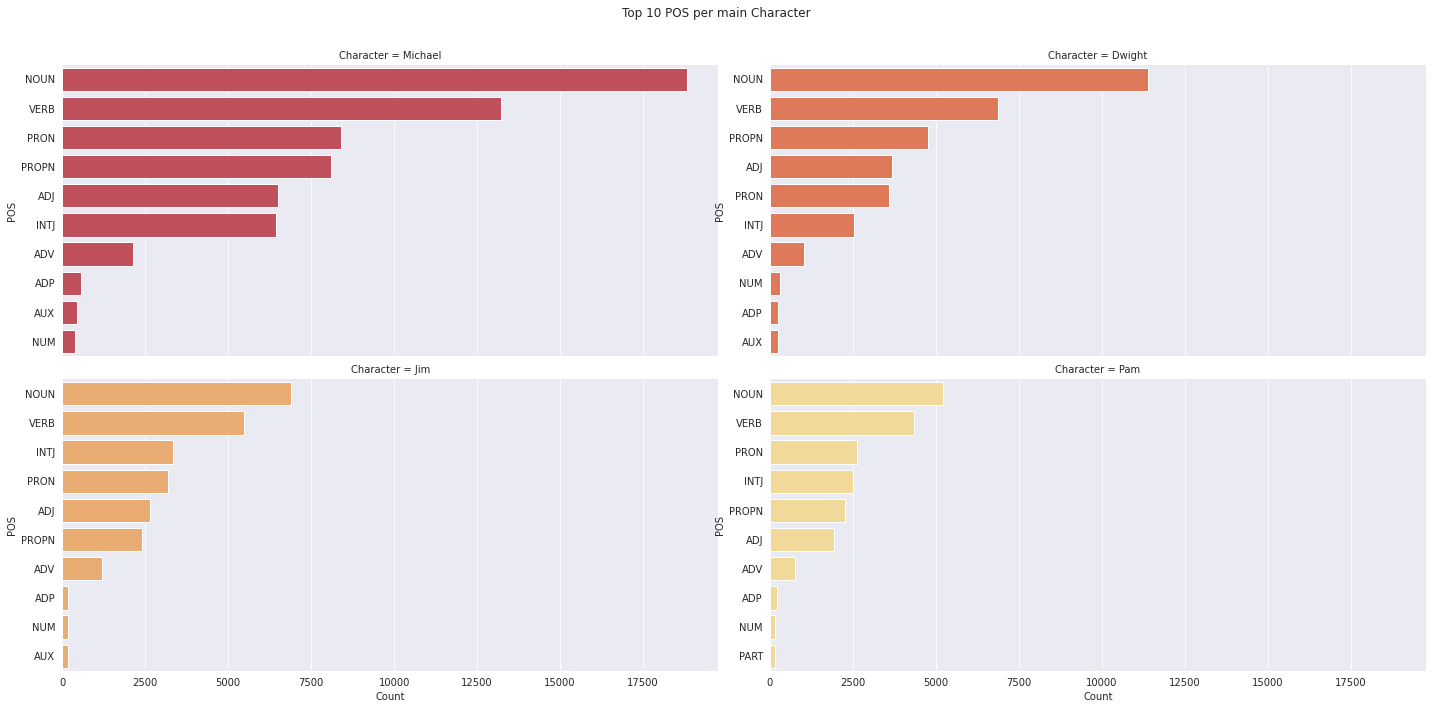

In [ ]:
# Visualize the top POS per main character
bar_plot = sns.catplot(data=pos_df, 
                       x="Count", y="POS",
                       col="Character",
                       hue="Character",
                       col_wrap=2,
                       kind="bar",
                       dodge=False,
                       sharey=False,
                       height=5,
                       aspect=2,
                       palette=sns.color_palette("Spectral", 9))

bar_plot.set(ylabel="POS")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Top 10 POS per main Character');

We see that the PRON belongs to one of the top 5 POS for every character. Let's dive into this by filtering for the words that are PROPN and visualize the most used words per main character for this POS.

In [ ]:
# Let's take a look at the most used PROPN
# Aggregate dataframe to show most common used PROPN
michael_propn_df = michael_pos_df[michael_pos_df['POS'] == 'PROPN'].copy()
michael_agg_propn_df = michael_propn_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)
michael_agg_propn_df['Character'] = 'Michael'

dwight_propn_df = dwight_pos_df[dwight_pos_df['POS'] == 'PROPN'].copy()
dwight_agg_propn_df = dwight_propn_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)
dwight_agg_propn_df['Character'] = 'Dwight'

jim_propn_df = jim_pos_df[jim_pos_df['POS'] == 'PROPN'].copy()
jim_agg_propn_df = jim_propn_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)
jim_agg_propn_df['Character'] = 'Jim'

pam_propn_df = pam_pos_df[pam_pos_df['POS'] == 'PROPN'].copy()
pam_agg_propn_df = dwight_propn_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)
pam_agg_propn_df['Character'] = 'Pam'

In [ ]:
# Concatenate dataframes of most frequent words
propn_df = pd.concat([michael_agg_propn_df, dwight_agg_propn_df,
                     jim_agg_propn_df, pam_agg_propn_df])

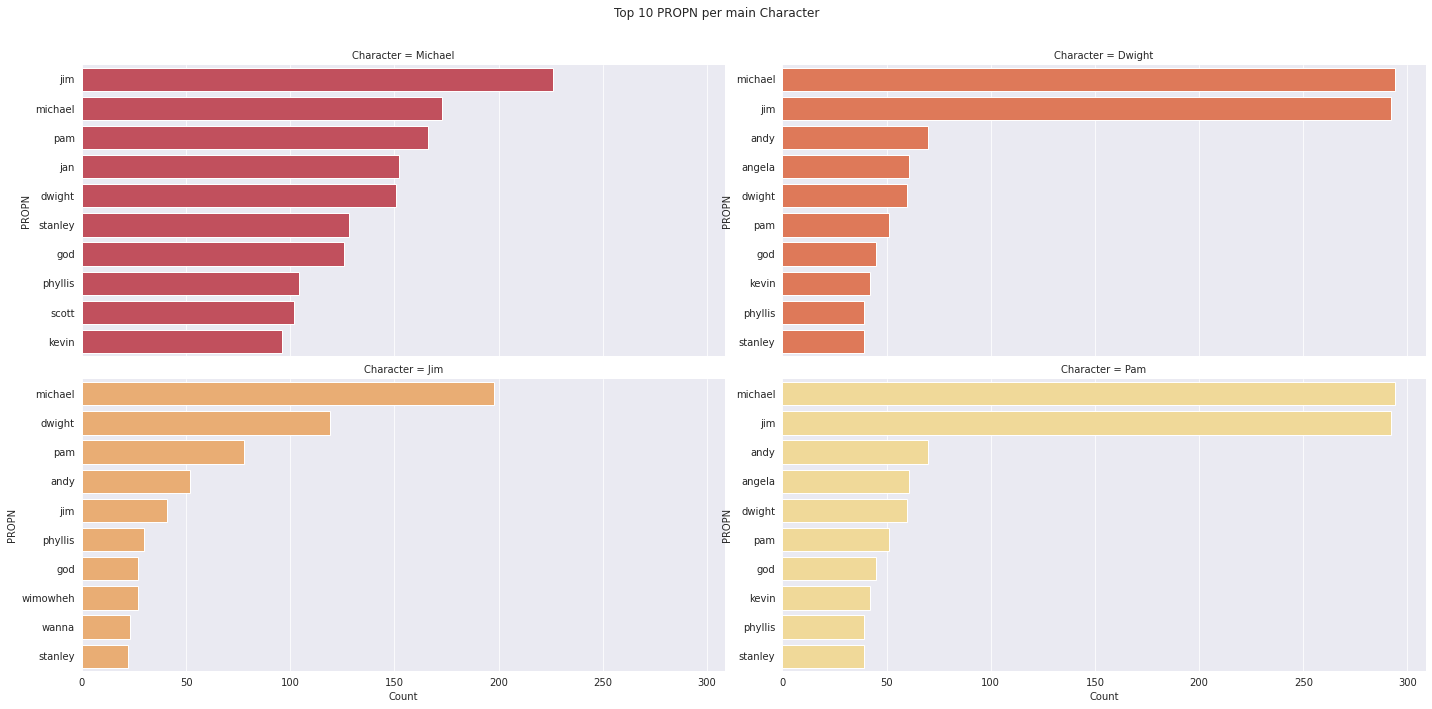

In [ ]:
# Visualize the top used propns per main character
bar_plot = sns.catplot(data=propn_df, 
                       x="Count", y="Word",
                       col="Character",
                       hue="Character",
                       col_wrap=2,
                       kind="bar",
                       dodge=False,
                       sharey=False,
                       height=5,
                       aspect=2,
                       palette=sns.color_palette("Spectral", 9))

bar_plot.set(ylabel="PROPN")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Top 10 PROPN per main Character');

We see that the main characters speak also a lot about the other main characters, with Michael as the most mentioned character by the three other main characters. Interestingly, Pam speaks also a lot about Jim, whereas Jim mentions Pam much less frequently. Conclusively, we can say that Michael is for real the main character of the series, as he is mentioned the most. 

Since we now got a better understanding of our dataset, let's next continue by creating our own word embeddings.

## Embeddings

Word embeddings are a way of representing words and phrases as vectors in a high-dimensional space. This allows words with similar meanings to be close together in the vector space, making it easier for natural language processing algorithms to understand the relationships between words and their meanings. In order to generate the word embeddings for our dataset, we will first have to tokenize them. This means we have to separate every word from the other words in a sentence in order to assign meaning to them more easily. 

In [ ]:
# Disable annotators for speed
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  """
  Tokenize text
  """
  return [t.text.lower() for t in nlp(text)] 

In [ ]:
# Apply tokenization
the_office_df['tokens'] = the_office_df['clean_text'].apply(lambda x: tokenize(x))
the_office_df.head()

,season,episode,title,speaker,line,clean_text,number_words,tokens
0,1,1,Pilot,michael,All right Jim. Your quarterlies look very good...,right jim quarterly look good thing library,14,"[right, jim, quarterly, look, good, thing, lib..."
1,1,1,Pilot,jim,"Oh, I told you. I couldn't close it. So...",oh i tell i close,9,"[oh, i, tell, i, close]"
2,1,1,Pilot,michael,So you've come to the master for guidance? Is ...,ve come master guidance grasshopper,14,"[ve, come, master, guidance, grasshopper]"
3,1,1,Pilot,jim,"Actually, you called me in here, but yeah.",actually i yeah,8,"[actually, i, yeah]"
4,1,1,Pilot,michael,"All right. Well, let me show you how it's done.",right let i,10,"[right, let, i]"


### Create Word2Vec Model

> 💡**Key-insight:** CBOW (Continuous Bag-of-Words) and skip-gram are two different algorithms used to learn word embeddings in natural language processing. The main difference between the two is the way they predict the target word given the context words. In CBOW, the model tries to predict the target word given the surrounding context words. In skip-gram, the model tries to predict the context words given the target word. This means that skip-gram considers each target word in isolation and tries to predict the context words based on that.

We will use skip-gram as it tends to work better with small datasets and represents less frequent words better (see: https://arxiv.org/pdf/1301.3781.pdf).

We can create a word2vec model by using `Word2Vec` from `gensim.models` ([see documentation](https://radimrehurek.com/gensim/models/word2vec.html)). We pass our created tokens to the model and define that we want output vectors of the shape `size=100`. Therefore, a word will be represented in a 100-dimensional space. Furthermore, we set the `window=7`, which corresponds to the maximum distance between a target word and words around the target word. So the 7 surrounding words on either side of the word are considered for contextualization. Lastly, we indicate that only words with a frequency of 5 or higher should be considered, and we indicate that we want to use skip-gram.

In [ ]:
word2vec_model = Word2Vec(the_office_df['tokens'],
                    size=100, # word vector dimensionality 
                    window=7, # context window size
                    min_count=5, # minimum word count
                    sg = 1, # skip- gram
                    seed=4, # for reproducability
                    workers=1 # for reproducability
                    )

In [ ]:
# Access vector for one word
word2vec_model.wv['office'], len(word2vec_model.wv['office'])

(array([-0.2193006 , -0.04961529,  0.3406928 ,  0.00686115, -0.11798362,
         0.13982363, -0.01831913,  0.01078223,  0.00318602, -0.08015312,
         0.2531884 ,  0.33662114, -0.2885896 , -0.21333273,  0.14640994,
         0.1278021 ,  0.32008672, -0.35897866, -0.00048891,  0.11665501,
         0.24042836,  0.30475488,  0.19315787, -0.30404523,  0.26863077,
        -0.04510552, -0.15449998,  0.16892457, -0.07722968,  0.2353204 ,
         0.09398623, -0.07982484,  0.11378898,  0.01612988,  0.00398059,
        -0.22904141, -0.35958943, -0.34762877, -0.13071078,  0.00243845,
         0.0025105 , -0.20914204,  0.21318258,  0.02860614, -0.0796204 ,
        -0.25834978,  0.04297074, -0.3657642 , -0.03541303,  0.06760836,
         0.06732775,  0.35555792,  0.04571339, -0.00163026, -0.04864478,
        -0.04049976,  0.06522768, -0.2640271 , -0.36539015,  0.3248894 ,
        -0.24689151, -0.06517315,  0.01925838, -0.00647988,  0.18972138,
         0.05392002, -0.12892596, -0.1157869 , -0.0

In [ ]:
len(word2vec_model.wv.vocab)

4175

Resulting, we see that we get a model where a word is represented in an array of length 100. In total, and after excluding stop words and less frequently used words, we end up with a vocabulary of 4'175 words.

### Exploring the model

Let us next explore the model by getting the most similar words in our embedding space for a specific word.

In [ ]:
# Get most similar words for michael
word2vec_model.wv.most_similar('michael', topn=5)

[('jan', 0.857669472694397),
 ('levinson', 0.8556392192840576),
 ('charles', 0.8415794968605042),
 ('scott', 0.840920090675354),
 ('jo', 0.8375601768493652)]

In [ ]:
# Get more similar words
similar_words = {
    search_term:
    [item[0] for item in word2vec_model.wv.most_similar([search_term], topn=5)]
    for search_term in ['office', 'michael', 'dwight', 'jim', 'pam', 'joke', 'paper']
}
similar_words

{'office': ['administrator', 'personal', 'performance', 'screw', 'florida'],
 'michael': ['jan', 'levinson', 'charles', 'scott', 'jo'],
 'dwight': ['vp', 'schrute', 'k', 'jo', 'congratulation'],
 'jim': ['halpert', 'pam', 'crush', 'beesly', 'karen'],
 'pam': ['halpert', 'beesly', 'jim', 'jessica', 'crush'],
 'joke': ['ugh', 'awful', 'lame', 'umm', 'bet'],
 'paper': ['company', 'printer', 'sell', 'price', 'business']}

We see that the most similar word for `michael` is `levison` and `jan`. This corresponds to Michael's boss and later girlfriend for some time during the series. Additionally, we see that `office` is near to `administrator`. This corresponds to a position in the series which is the office administrator. Next, we see that `paper` is most similar to `company`, which makes sense as Dunder Mifflin is a paper company. 

Let us next inspect the strength of the similarities between two words in our embeddings.

In [ ]:
# Let's inspect similarities
word2vec_model.wv.similarity('paper', 'company')

0.9111088

In [ ]:
# Another similaritiy
word2vec_model.wv.similarity('michael', 'scott')

0.84092015

In [ ]:
# Another similaritiy
word2vec_model.wv.similarity('jim', 'pam')

0.81849647

In [ ]:
# Another similaritiy
word2vec_model.wv.similarity('love', 'ship')

0.4867979

In [ ]:
# Another similaritiy
word2vec_model.wv.similarity('paper', 'coffee')

0.42930645

Similarity is expressed as a value between 0 and 1, where 1 correponds to high  and 0 to low similarity.

`paper` & `company` have a very strong similarity, which makes sense given the context of our dataset.
Next we see that `michael` & `scott` and `jim` & `pam` have a stong similarity. Former representing the first and last name and latter the names of `jim` & `pam` as couple. On the other hand, we see that `love` & `ship` as well as `paper` & `coffee` are considered to be not very close, which makes sense.

### Visualise Embeddings

As a next step, we can visualize our embeddings by plotting them into a 2- or 3-dimensional space. This should help to get a better understanding of the distances between words. In order to do this, we need to reduce the dimensionality of our embedding spaces to 2 or 3 dimensionalities. To do this, we will use `TSNE` (t-Distrubuted Stochastic Neighbor Embedding) of `sklearn` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). t-SNE helps to visualise high-dimensional (100-dimensional in our case) data in a lower-dimensional space (2- or 3-dimensional space in our case). It works by converting the high-dimensional data into a lower-dimensional space, such that the distances between points in the original high-dimensional space are preserved as closely as possible in the lower-dimensional space. With t-SNE we can reveal the underlying structure of the data by grouping similar data points together in the lower-dimensional space. This makes it useful as it can help us to identify patterns and relationships in the data that may not be immediately apparent. 

In order to get a visualization that is clear, we will only inspect a sample of 150 words of our vocabulary. We will take the 150 most frequent words of our embedding space.

We will set the `perplexity` of the model to 7, which corresponds to the amount of information that should be preserved in the lower-dimensional space in the form of the effective number of neighbors, which come from the points in the high-dimensional space. We can think of it as a guess about the number of close neighbors each point has ([see more information](https://distill.pub/2016/misread-tsne/)). 





In [ ]:
words = word2vec_model.wv.index2word[0:149]      # get the word forms of voculary sample
wvs = word2vec_model.wv[words]                     # get embeddings of word forms


tsne = TSNE(n_components=2, # Dimensions - We want to create a 2D-plot
            random_state=0, 
            n_iter=7000, # Maximum number of iterations for the optimization
            perplexity=7) 

T = tsne.fit_transform(wvs)

# Create DataFrame for visulization
embeddings_df_2d = pd.DataFrame(T)
embeddings_df_2d['word'] = words
embeddings_df_2d.head()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,0,1,word
0,-2.826881,-17.429295,i
1,-5.149011,-27.100327,know
2,-31.973701,-6.008661,oh
3,-19.696272,-22.787214,like
4,-45.404438,-7.053627,yeah


In [ ]:
fig = px.scatter(embeddings_df_2d,
                 x=0, y=1, text="word",
                 opacity=0.7,
                 color_discrete_sequence=["darkseagreen"],
                 title="visualisation of word embeddings",
                 template="plotly_dark",
                 labels={
                     "0": "x",
                     "1": "y",
                 })

fig.update_traces(textposition="top center")

> 💡**Key-insight:** The embedding space shows some very awesome things. We for example see that `man` & `woman` as well as `minute`& `second` are near to each other. This means the word seem to be of similar character. When it comes to the series-specific vocabulary, we see that `dunder` & `mifflin` & `paper` & `company` as well as `pam` & `jim` are very near to each other. Awesome as well is that `angela` & `oscar` & `kevin` are mapped near each other, who all three represent the accounting department and are often referred to as that. Generally, we can therefore say that our model learned the general context of things as well as the specific context/similarity of series-specific words, by mapping relationships between words that belong together near each other. 


Let visualise the embeddings next in a 3-dimensional space. 

In [ ]:
# Create TSNE with 3 Dimensions
tsne = TSNE(n_components=3, # Dimensions - We want to create a 3D-plot
            random_state=0, 
            n_iter=7000, # Maximum number of iterations for the optimization
            perplexity=5)

T = tsne.fit_transform(wvs)

# Create DataFrame for visulization
embeddings_df_3d = pd.DataFrame(T)
embeddings_df_3d['word'] = words
embeddings_df_3d.head()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,0,1,2,word
0,12.974942,-227.915222,-9.422795,i
1,37.582581,-159.394348,-71.545227,know
2,185.798645,88.784233,129.854691,oh
3,-20.011538,-51.682571,107.871391,like
4,250.929153,-22.472591,-60.255108,yeah


In [ ]:
fig = px.scatter_3d(embeddings_df_3d,
                    x=0, y=1, z=2,
                    text="word",
                    opacity=0.7,
                    color_discrete_sequence=["darkseagreen"],
                    title="3d-visualisation of word embeddings",
                    template="plotly_dark",
                     labels={
                     "0": "x",
                     "1": "y",
                     "2": "z"
                 })

fig.show()

> 💡**Key-insight:** The 3d-visualisation gives us another view of our word embeddings. For some points, we can better see that they are very close to each other. On the other hand some words that were close together in the 2-dimensional visualization are not that close anymore. We can see that it is not always possible to directly compare the locations of points in a 2-dimensional t-SNE plot to a 3-dimensional t-SNE plot, because the underlying distances between points may not be preserved perfectly in the lower-dimensional space.


To get an additional understanding of the words in our embedding space, let's next create a plot that also indicates the POS for every word in a 2-dimensional and 3-dimensional space. 

In [ ]:
## Add pos tags
nlp = spacy.load("en_core_web_sm")
def pos_tag(word):
  """
  Gets Part of speech tag for a word.
  """
  doc = nlp(word)
  return doc[0].pos_

# Apply function to dataframe
embeddings_df_2d['POS'] = embeddings_df_2d['word'].apply(lambda x: pos_tag(x))
embeddings_df_3d['POS'] = embeddings_df_3d['word'].apply(lambda x: pos_tag(x))

In [ ]:
fig = px.scatter(embeddings_df_2d,
                 x=0, y=1, text="word",
                 color='POS',
                 opacity=0.7,
                 title="visualisation of word embeddings",
                 template="plotly_dark",
                labels={
                    "0": "x",
                    "1": "y",
                 })

fig.update_traces(textposition="top center")

We see that very near words are mostly of the same POS. We see for example `huh`, `yes`, `um`, and `yes` near to each other which all are INTJ (interjection). Additionally, two VERB (verbs) with `help` & `need` are clustered near each other. Unfortunately, our POS-tagging did not work correctly for every word, as we can see with `mifflin` which was tagged as Verb but should be a PROP (proper noun). However, we have combinations of very near words that are of the same POS (e.g. `paper` & `company` (NOUN), `business` & `sale` (NOUN), `jim` & `pam` (PROPN).

Let's also inspect the POS-colored embeddings in a 3-dimensional vislualization.

In [ ]:
fig = px.scatter_3d(embeddings_df_3d,
                    x=0, y=1, z=2,
                    text="word",
                    color='POS',
                    opacity=0.7,
                    title="3d-visualisation of word embeddings",
                    template="plotly_dark",
                    labels={
                      "0": "x",
                      "1": "y",
                      "2": "z"
                 })

fig.show()

As with the 2-dimensional visualization, we can see some clusters of similar POS together. Conclusively, we can say that very near clusters of words tend to have the same POS. However, we have to be careful as our POS tagging has some flaws and is not tagging every word correctly.

### Visualizing similar words

Let's continue by inspecting the embedding space of most similar words. We will do the same as the section before, by first plotting the 2-dimensional and afterward 3-dimensional representation of the embedding space. 

Before we do this, we have to be aware that the closeness of a word in our resulting t-SNE visualization will not necessarily correspond to the strength of similarity of a word. This comes as the similarity comes from the global distances (100-dimensional space) and we reduce them to a lower dimension, which can lead to that by optimizing to local distances the accuracy of similarity is not preserved ([see related discussion](https://datascience.stackexchange.com/questions/10802/can-closer-points-be-considered-more-similar-in-t-sne-visualization)). This also means that axes in the low-dimensional space don't have a particular meaning. Therefore, while inspecting a t-SNE visualization the size of the clusters does not matter, nor does the inter-cluster distance. What is of importance, however, is the clusters itself, concretely, which data points are clustered together ([see related discussion](https://stats.stackexchange.com/questions/331745/how-to-interpret-t-sne-plot)). In order to get clear clusters, we change the perplextiy to 2.

In [ ]:
def plot_closestwords(model, word, size, topn=50, z_axis=False):
  """
  Selects topn similar words for a given word and calculates the distance with TSNE.
  Based on z_axis it will either calulate 3 or 2 dimensions.
  Plots the corresponding words as scatterplot and hightlights word.
  """
    
  arr = np.empty((0,size), dtype='f')
  word_labels = [word]
  close_words = model.wv.similar_by_word(word, topn=topn)
  arr = np.append(arr, np.array([model[word]]), axis=0)
  for wrd_score in close_words:
      wrd_vector = model[wrd_score[0]]
      word_labels.append(wrd_score[0])
      arr = np.append(arr, np.array([wrd_vector]), axis=0)
      
  if z_axis:
    tsne = TSNE(n_components=3, 
                random_state=0, 
                n_iter=7000,
                perplexity=2) # low perplexity to make clear clusters
  else:
    tsne = TSNE(n_components=2, 
                random_state=0,
                n_iter=7000,
                perplexity=2) # low perplexity to make clear clusters
    
  Y = tsne.fit_transform(arr)

  # Create dataframe
  closestwords_df = pd.DataFrame()
  closestwords_df["x"] = Y[:, 0]
  closestwords_df["y"] = Y[:, 1]
  closestwords_df["word"] = word_labels
  closestwords_df["similarity"] = closestwords_df["word"].map(dict(word2vec_model.wv.similar_by_word(word, topn=topn)))

  # Add third axis if z_axis
  if z_axis:
    closestwords_df["z"] = Y[:, 2]

  # Create plots
  
  # Filter point for word to highlight in plot
  highlight_entry = pd.DataFrame(closestwords_df[closestwords_df['word'] == word])

  # 3d if three axis
  if z_axis:
    fig = px.scatter_3d(closestwords_df,
                        x="x", y="y", z="z",
                        text="word",
                        color="similarity",
                        color_continuous_scale="Viridis",
                        opacity=0.7,
                        title=f"Most similar to '{word}'",
                        template="plotly_dark")
    fig.add_traces(
        px.scatter_3d(highlight_entry, 
                   x="x", y="y", z="z",
                   text="word").update_traces(marker_color="firebrick").data
        )
    
  else:
    fig = px.scatter(closestwords_df,
                     x="x", y="y",
                     text="word",
                     color="similarity",
                     color_continuous_scale="Viridis",                 
                     opacity=0.7,
                     title=f"Most similar to '{word}'",
                     template="plotly_dark")
    fig.add_traces(
        px.scatter(highlight_entry, 
                   x="x", y="y",
                   text="word").update_traces(marker_color="firebrick").data
        )


  fig.update_traces(textposition="top center")
  fig.show()
    

In [ ]:
plot_closestwords(word2vec_model, 'paper', size=100, topn=30)

<ipython-input-63-3df7a5c5e33e>:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-63-3df7a5c5e33e>:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
plot_closestwords(word2vec_model, 'paper', size=100, topn=30, z_axis=True)

<ipython-input-63-3df7a5c5e33e>:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-63-3df7a5c5e33e>:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# Get similarity values for 10 most similar words
dict(word2vec_model.wv.similar_by_word("paper", topn=10))

{'company': 0.9111088514328003,
 'printer': 0.8935049176216125,
 'sell': 0.8833920955657959,
 'price': 0.8739843368530273,
 'business': 0.8684757351875305,
 'product': 0.8627046346664429,
 'service': 0.8618991374969482,
 'customer': 0.8604362607002258,
 'infinity': 0.8422693014144897,
 'sabre': 0.8393679857254028}

As already mentioned before, nearer words do not necessarily mean to be of higher similarity in the 2-dimensional or 3-dimensional space. The important thing is the clusters that are built. We for example see a very nice cluster of the most similar words (`printer`, `company`, `
sell`) together with `paper` in the 2-dimensional visualization. This cluster is then kind of visible in the 3-dimensional visualzation, but `sell` being further away from `paper`.

In [ ]:
plot_closestwords(word2vec_model, 'sell', size=100, topn=40)

<ipython-input-63-3df7a5c5e33e>:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-63-3df7a5c5e33e>:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
plot_closestwords(word2vec_model, 'sell', size=100, topn=40, z_axis=True)

<ipython-input-63-3df7a5c5e33e>:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-63-3df7a5c5e33e>:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# Get similarity values for 10 most similar words
dict(word2vec_model.wv.similar_by_word("sell", topn=10))

{'printer': 0.9546183943748474,
 'website': 0.9041635394096375,
 'property': 0.8995882272720337,
 'supply': 0.897759735584259,
 'small': 0.8902087807655334,
 'company': 0.8869265913963318,
 'cost': 0.885623037815094,
 'line': 0.884706974029541,
 'paper': 0.8833921551704407,
 'drug': 0.8790912628173828}

As with `paper` before, we see that in the 2D visualization the most similar words are close to the chosen word (in this case `sell`). Additionally, we see some nice clusters in the 2-dimensional visualization. In the 3D visualization, the clusters are not that clearly visible.

In [ ]:
plot_closestwords(word2vec_model, 'funny', size=100, topn=40)

<ipython-input-63-3df7a5c5e33e>:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-63-3df7a5c5e33e>:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
plot_closestwords(word2vec_model, 'funny', size=100, topn=40, z_axis=True)

<ipython-input-63-3df7a5c5e33e>:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-63-3df7a5c5e33e>:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# Get similarity values for 10 most similar words
dict(word2vec_model.wv.similar_by_word("funny", topn=10))

{'joke': 0.920020580291748,
 'bet': 0.9152133464813232,
 'hilarious': 0.9139258861541748,
 'lame': 0.9086601734161377,
 'awful': 0.9030994176864624,
 'pete': 0.890714168548584,
 'jealous': 0.8905116319656372,
 'smart': 0.8891927003860474,
 'horrible': 0.8869273662567139,
 'hide': 0.8868123292922974}

With `funny` we observe that the most similar word `joke` is located very near to `funny` in the 2D plot, and we see good clusters. Nevertheless, the clusters are much hardly visible in the 3-dimensional plot.

> 💡**Key-insight:** Visualizing the embeddings of the most similar words in a 2- & 3-dimensional space helped us to get a better understanding of the underlying patterns/structures of the word embeddings. However, we saw that t-SNE can create nice clusters in the 2-dimensional visualization, but that these clusters are then not really visible in the 3-dimensional visualization. This can have happened due to one of the following points:
>
>* The differentiability of our data is not enough. In such a case we would need more data to make better generalizations.
>* t-SNE is trying to differentiate main clusters, but not sub-clusters, which could be represented in the most similar words. To improve this we could maybe select a point, isolate it and start t-SNE again.


Weakness of Word2Vec

Before we move on to comparing our model with pretrained models, it's important to be aware of the weakness of Word2Vec models. Concretely, this weakness comes in the form that it's not possible to get similar words for a word that is not in the vocabulary. Overall, this means we cannot get any insights about words that are not in our vocabulary. 

In [ ]:
try:
  print(word2vec_model.wv.most_similar('superhero'))
except KeyError as e:
  print(f"{e}: Can't therefore find any similar words")

"word 'superhero' not in vocabulary": Can't therefore find any similar words


### Pre-trained word embeddings

Let's next compare our model to pre-trained word embeddings. We can best compare this if we inspect the similar words for an input word in our Word2Vec model and a pretrained model. For this we will use the following pretrained word embeddings:

* `glove-wiki-gigaword-100`: pre-trained vectors based on Wikipedia 2014 and [Gigaword 5](https://catalog.ldc.upenn.edu/LDC2011T07), 6B tokens, 400K vocab
* `fasttext-wiki-news-subwords-300`: pre-trained vectors based on subword infomation on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset, 16B tokens, 1M word vectors

The main difference between the two is that GloVe uses global statistics to generate word vectors and is an unsupervised method, while Fasttext is a supervised methond and uses local context.  Instead of learning vectors for words directly, Fasttext represents each word as an n-gram of characters. This means that GloVe word vectors may be more generalizable, while Fasttext word vectors may be more accurate for specific tasks. ([see](https://dzone.com/articles/glove-and-fasttext-two-popular-word-vector-models#:~:text=GloVe%20showed%20us%20how%20we,the%20different%20models%20is%20best.))


In [ ]:
glove_vectors = api.load("glove-wiki-gigaword-100")

In [ ]:
glove_vectors.most_similar('office')

[('offices', 0.7925063371658325),
 ('house', 0.7581614851951599),
 ('department', 0.7455127239227295),
 ('administration', 0.7370805740356445),
 ('post', 0.7357223629951477),
 ('government', 0.71703040599823),
 ('public', 0.7134413123130798),
 ('official', 0.7123508453369141),
 ('officials', 0.7025830149650574),
 ('headquarters', 0.695116400718689)]

In [ ]:
# Compare pretrained similar words with similar words of own embedding

# 5 most frequent words in embedding space
frequent_words = word2vec_model.wv.index2word[:5]

for word in frequent_words:

  print(f"Own word2vec embedding space similar words for '{word}'")
  pprint.pprint(word2vec_model.wv.most_similar(word))

  print(f"Pretrained Glove embedding space similar words for '{word}'")
  pprint.pprint(glove_vectors.most_similar(word))
  print("\n")
  print(50*"x")

Own word2vec embedding space similar words for 'i'
[('truth', 0.8661414980888367),
 ('angry', 0.8568219542503357),
 ('course', 0.8556854724884033),
 ('stress', 0.8492861986160278),
 ('somebody', 0.8482954502105713),
 ('voice', 0.8437160849571228),
 ('exactly', 0.8373446464538574),
 ('cause', 0.8373377919197083),
 ('conversation', 0.8366914391517639),
 ('clearly', 0.8334865570068359)]
Pretrained Glove embedding space similar words for 'i'
[("'d", 0.9060310125350952),
 ("'m", 0.904269814491272),
 ('you', 0.9023691415786743),
 ('know', 0.9019697308540344),
 ("'ve", 0.9010248184204102),
 ('we', 0.8958863019943237),
 ("n't", 0.8894177079200745),
 ('think', 0.8826203346252441),
 ('me', 0.8774940967559814),
 ('really', 0.876028299331665)]


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Own word2vec embedding space similar words for 'know'
[('angry', 0.9443157911300659),
 ('nervous', 0.9431884288787842),
 ('honest', 0.9425049424171448),
 ('handle', 0.9344814419746399),
 ('exactly', 0.9338

In [ ]:
# Compare for domain specific words
domain_words = ['office', 'paper', 'scranton', 'michael', 'joke', 'manager']

for word in domain_words:

  print(f"Own word2vec embedding space similar words for {word}")
  pprint.pprint(word2vec_model.wv.most_similar(word))

  print(f"Pretrained Glove embedding space similar words for {word}")
  pprint.pprint(glove_vectors.most_similar(word))
  print("\n")
  print(50*"x")

Own word2vec embedding space similar words for office
[('administrator', 0.9086772203445435),
 ('personal', 0.8896874189376831),
 ('performance', 0.8797156810760498),
 ('screw', 0.875545859336853),
 ('florida', 0.872410237789154),
 ('form', 0.8698506951332092),
 ('information', 0.86692214012146),
 ('interview', 0.8626479506492615),
 ('lead', 0.8626405596733093),
 ('rumor', 0.8625608682632446)]
Pretrained Glove embedding space similar words for office
[('offices', 0.7925063371658325),
 ('house', 0.7581614851951599),
 ('department', 0.7455127239227295),
 ('administration', 0.7370805740356445),
 ('post', 0.7357223629951477),
 ('government', 0.71703040599823),
 ('public', 0.7134413123130798),
 ('official', 0.7123508453369141),
 ('officials', 0.7025830149650574),
 ('headquarters', 0.695116400718689)]


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Own word2vec embedding space similar words for paper
[('company', 0.9111088514328003),
 ('printer', 0.8935049176216125),
 ('sell', 0.8833920

When comparing the GloVe model with our Word2Vec model we see that we get totally different similar words to the most frequent words in our vocabulary. On the other hand, when comparing to context-based words we see that Glove has places that are near Scranton as most similar words to it, whereas our model refers mostly to series-specific words and not really any geographical places. When inspecting the similar words for `michael` we get mostly other character names of the series (female, male, last and first names), whereas with Glove we get mostly male first names. Interesting to see is that in both models we have `david` as to be of high similarity. With our own Word2Vec model almost the same or similar words as with our Glove model. However, the similarity values for our own model are much higher than those of the most similar words in Glove. Generally, the similar words of our own model seem overall to be higher than the one from Glove. 

In [ ]:
# Fasttext model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

print(fasttext_model.most_similar('teacher'))


[('educator', 0.7812017202377319), ('schoolteacher', 0.7797069549560547), ('teachers', 0.7635692358016968), ('student', 0.756062388420105), ('teacher-', 0.7527834177017212), ('school-teacher', 0.7409082055091858), ('paraeducator', 0.7359000444412231), ('teacher-librarian', 0.7357273101806641), ('teacher-researcher', 0.7300713658332825), ('teacher-parent', 0.7287502884864807)]


In [ ]:
# Compare pretrained similar words with similar words of own embedding

# 5 most frequent words in embedding space
frequent_words = word2vec_model.wv.index2word[:5]

for word in frequent_words:

  print(f"Own word2vec embedding space similar words for '{word}'")
  pprint.pprint(word2vec_model.wv.most_similar(word))

  print(f"Pretrained Fasttext embedding space similar words for '{word}'")
  pprint.pprint(fasttext_model.most_similar(word))
  print("\n")
  print(50*"x")

Own word2vec embedding space similar words for 'i'
[('truth', 0.8661414980888367),
 ('angry', 0.8568219542503357),
 ('course', 0.8556854724884033),
 ('stress', 0.8492861986160278),
 ('somebody', 0.8482954502105713),
 ('voice', 0.8437160849571228),
 ('exactly', 0.8373446464538574),
 ('cause', 0.8373377919197083),
 ('conversation', 0.8366914391517639),
 ('clearly', 0.8334865570068359)]
Pretrained Fasttext embedding space similar words for 'i'
[('u', 0.8394169211387634),
 ('I', 0.8177322149276733),
 ('j', 0.7933907508850098),
 ('r', 0.7755774259567261),
 ('l', 0.7718341946601868),
 ('ı', 0.766356348991394),
 ('f', 0.7550612688064575),
 ('e', 0.7479370832443237),
 ('h', 0.745825469493866),
 ('k', 0.7428181171417236)]


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Own word2vec embedding space similar words for 'know'
[('angry', 0.9443157911300659),
 ('nervous', 0.9431884288787842),
 ('honest', 0.9425049424171448),
 ('handle', 0.9344814419746399),
 ('exactly', 0.9338226318359375),
 ('h

In [ ]:
# Compare for domain specific words
domain_words = ['office', 'paper', 'michael', 'joke', 'manager']

for word in domain_words:

  print(f"Own word2vec embedding space similar words for {word}")
  pprint.pprint(word2vec_model.wv.most_similar(word))

  print(f"Pretrained Fasttext embedding space similar words for {word}")
  pprint.pprint(fasttext_model.most_similar(word))
  print("\n")
  print(50*"x")

Own word2vec embedding space similar words for office
[('administrator', 0.9086772203445435),
 ('personal', 0.8896874189376831),
 ('performance', 0.8797156810760498),
 ('screw', 0.875545859336853),
 ('florida', 0.872410237789154),
 ('form', 0.8698506951332092),
 ('information', 0.86692214012146),
 ('interview', 0.8626479506492615),
 ('lead', 0.8626405596733093),
 ('rumor', 0.8625608682632446)]
Pretrained Fasttext embedding space similar words for office
[('offices', 0.825912594795227),
 ('office-', 0.7802857160568237),
 ('offfice', 0.7710880041122437),
 ('sub-office', 0.7452528476715088),
 ('office-holder', 0.7319200038909912),
 ('office--and', 0.7292572855949402),
 ('office-wide', 0.708924412727356),
 ('office-boy', 0.7085444927215576),
 ('non-office', 0.6998997926712036),
 ('offic', 0.6981836557388306)]


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Own word2vec embedding space similar words for paper
[('company', 0.9111088514328003),
 ('printer', 0.8935049176216125),
 ('sell',

When comparing the Fasttext model with our Word2Vec model, we see that the similar words of the Word2Vec model are other words (in meaning), but with Fasttext we get the same word written in different ways (with punctuation and wrongly written). For the word `i` we get other letters in Fasttext. When it comes to context-specific words, Fasttext has the searched word often in the similar words included with some extra information (e.g with `office` we get `sub-office`, `office-holder`). Additionally, and as already seen in the comparison of our model to the Glove model, the similarity values for our Word2Vec model are generally higher. This can probably be led back to the higher number of training data in both pre-trained models.

Conclusively, we can say that a model is highly adapted to the training data it was trained on. Our own model has its benefits in it's focus on the Office series. It knows patterns of first & last names as well close relationships between characters (e.g. `jim` & `pam`). Additionally, it knows that a company is most likely a paper company, which is in the focus of the data. However, it's cons are that it is highly specialized on the context trained on and that it can't make any assumptions/predictions of words outside the vocabulary. On the other hand, `glove-wiki-gigaword-100`, `fasttext-wiki-news-subwords-300` are big pre-trained model that generalize much better and can save time compared to training a model from scratch. One potential drawback, however, is that these models are often large and require a significant amount of computational resources to use. Lastly, Fasttext provides especially value with it's break down of words into ngrams, which makes it possible to handle words outside of the vocabulary. 

#### WordNet

As a final step [WordNet](https://wordnet.princeton.edu/) is introduced that can be used to inspect the quality of our Word2Vec model. 

WordNet is a lexical database that provides a hierarchy of word meanings and relationships. WordNet organizes English words into synsets, which are sets of synonyms that share a common meaning. With the help of synsets it's possible to distinguish between different meanings of words.


In [ ]:
# Wordnet
from nltk.corpus import wordnet as wn

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

word = "office"

syns = wn.synsets(word) 

# An example of a synset: 
print(len(syns), syns)

# Just the word: 
print(syns[0].lemmas()[0].name()) 

# Definition of that first synset: 
print(syns[0].definition()) 

# Examples of the word in use in sentences: 
print(syns[0].examples()) 

# Synonmyes and antonyms
synonyms = [] 
antonyms = [] 
for syn in wn.synsets(word): 
	for l in syn.lemmas(): 
		synonyms.append(l.name()) 
		if l.antonyms(): 
			antonyms.append(l.antonyms()[0].name()) 

print(set(synonyms)) 
print(set(antonyms))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


7 [Synset('office.n.01'), Synset('agency.n.01'), Synset('function.n.03'), Synset('office.n.04'), Synset('office.n.05'), Synset('office.n.06'), Synset('position.n.06')]
office
place of business where professional or clerical duties are performed
['he rented an office in the new building']
{'spot', 'situation', 'bureau', 'function', 'government_agency', 'federal_agency', 'billet', 'role', 'post', 'position', 'part', 'power', 'agency', 'office_staff', 'office', 'place', 'authority', 'business_office', 'berth'}
set()


We see that for `office` there are 7 different synsets. For a synset we can get the definition and also get examples. When we inspect the synonyms and antonyms, we see that the synsets for `office` have different synonyms and no antonyms. 

By comparing our model to WorNed by word relatedness evaluation ([see example](https://towardsdatascience.com/automatic-word-relatedness-evaluation-wordnet-spacy-wikidata-api-9fd1c72ac73c)), we could get additional information of the strengths and limitations of our Word2Vec model, and identify areas where it could be improved. Although our model is trained on the content of the Office and therefore highly adapted to the context of the series, this would be a recommended next step to improve our model but lies outside the scope of this notebook.

## Summary


In this notebook, we analyzed the transcript of the series the Office. We imported the data, cleaned and transformed it, and conducted an EDA afterward. Next, we created word embeddings by creating our own Word2Vec model, which we explored in the next part by visualizing different aspects of our embeddings in a 2- and 3-dimensional space. Lastly, we compared our model to a pre-trained GloVe and Fasttext model.

Throughout the notebook, we verified our assumption that our own Word2Vec model will learn the context of specific words very well and calculate them as close together in the embedding space. Conclusively, we were able to gain the following insights that enable us to answer our intially stated questions:

* Michael, Jim, Dwight, and Pam are considered the main characters of the series based on the lines they have and how much they refer to each other.
* Relationships of different characters and words are visible in the embedding space by mapping names as close together (e.g. Jim & Pam, Angela & Oscar & Kevin as accounting department).
* Words that are often useed together in the same context are near each other in the embedding space (e.g. Dunder & Mifflin, Paper & Sell, Joke & Funny).
* The similar words to central words in our embedding space make sense (e.g. Paper near to Company, Sell & Printer).
* Pre-trained models can save time in training and building and result in more generalizable results than our own model. However, our model is highly specialized on the context of our training data and represents the context there pretty well.

**Where to go from here:** In this notebook, we created our own Word2Vec model based on the transcript of the series the Office. As a next step, we could first try to evaluate the performance of our model, for example by performing a relatedness evaluation with WordNet. This or other evaluation procedures should help us determine more thoroughly the strengths and weaknesses of our model. We could then in the next step fine-tune our model with additional data and lastly even combine our Word2Vec model with other natural language processing techniques, such as creating a recurrent neural network or transformers. With this, we could tackle tasks such as language generation (a new season of the Office based on AI?) or sentiment analysis during the scenes itself.






